### The following techniques will be used in this notebook- 

1. Deep Neural Networks with different activation functions <br>
2. Autoencoder 

In [1]:
'''
    ----------------------------------------------------------------------------------------------
    April 2022
    Dr. Maryam Khanahmadi
    Postdoctoral Researcher
    Wallenberg Center for Quantum Technology (WACQT)
    Chalmers University of Technology
    
    m.khanahmadi94@gmail.com
    Data set used: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction
    ----------------------------------------------------------------------------------------------
    
    
    In this notebook we are using Airline Passenger Satisfaction data set where the 
    satisfaction level of a customer was registered based on their gender, age, customer type, 
    and how they rated different aspects of the flight such as distance travelled, food and drinks, 
    entertainment, on-board service, legroom etc.
    
    
    We plan to employ deep neural network models which shall be able to predict the customer satisfaction.
    This notebook gives a good comparison between various Supervised Machine Learning algorithms such as 
    Logistic regression, decision trees etc. and deep neural network (DNN) since the data set used is the same.
    
    Just as a reminder, the maximum performance using a supervised machine learning algorithm was achieved 
    using Decision trees where the ROC_AUC score was 0.946.
    
    
''';

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support as score
from keras.models import Model
import tensorflow

In [3]:
# All the functions will be placed below- 

def _encoding(DS, cols):
    '''
    This function takes the data set and column indexes as input which needs to be label encoded.
    There are two possible options- one hot encoding or label encoding
        
        
    Arguments- 
        DS   :  The data set
        cols :  Index of the columns which needs to be encoded
        
        
    Returns-
        df   : Encoded data set 
    '''

    num_of_cols = len(cols)
    le = LabelEncoder()
    for i in range(num_of_cols):
        DS.iloc[:,cols[i]] = le.fit_transform(DS.iloc[:,cols[i]])
    return DS



def _Scaler(df, Stype):
    
    '''
    This function does scaling of the dataframe and return the dataframe
    with scaled values.
    Two possible options - "Minmax" for MinMax scaler and "Stand" for Standard scaler
    
    Arguments-
        df          : Dataframe
        Stype       : Type of scaler - MinMax or Standard Scaler
        
    Returns-
        df          : Updated dataframe with scaled values for the numeric columns
      
    '''
    num_cols = df.columns[np.where(df.dtypes != object)]
    if Stype == 'MinMax':
        sc = MinMaxScaler()
        df[num_cols] = sc.fit_transform(df[num_cols])  
        
        
    elif Stype == 'Stand':
        sc = StandardScaler()
        df[num_cols] = sc.fit_transform(df[num_cols]) 
        
    else:
        print("Stype not matching... Applying Standard Scaler")
        sc = StandardScaler()
        df[num_cols] = sc.fit_transform(df[num_cols])
           
    return df


## Data exploration

In [4]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")
df = pd.concat([train_set, test_set])

# Before we start, we would remove some of the irrelevant features from the data set such as ID etc.
df = df.drop(columns=['Unnamed: 0','id'], axis = 1)
df = df.reset_index()

df.head(8)

,index,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,5,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,6,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,7,Female,Loyal Customer,52,Business travel,Business,2035,4,3,4,...,5,5,5,5,4,5,4,4,0.0,satisfied


## Feature engineering

In [5]:
'''
    The useful non numeric features such as type of travel, gender, customer type etc. 
    has to be converted into numeric values.
    
    However, when the number of possible cases per column is 2 then that can be represented by
    0 and 1 in the same column.
    
    As the number of possible cases increase, e.g. 'Class' here has 3 possible options- Business, Eco 
    and Eco Plus and thus it becomes relevant to add those as separate features which is useful while fitting
    the data.
    
    The function "encoding" takes care of such cases and return a transformed dataframe.

'''

cols = np.where(df.dtypes == object)[0]
df = _encoding(df, cols)

# Shuffling the feature "satisfaction" at the end of the DataFrame
cols_at_end = ['satisfaction']
df = df[[c for c in df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df]]

In [6]:
# Scale the data frame using MinMax Scaler
df.iloc[:,0:len(df.columns)-1] = _Scaler(df.iloc[:,0:len(df.columns)-1], 'MinMax')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   index                              129880 non-null  float64
 1   Gender                             129880 non-null  float64
 2   Customer Type                      129880 non-null  float64
 3   Age                                129880 non-null  float64
 4   Type of Travel                     129880 non-null  float64
 5   Class                              129880 non-null  float64
 6   Flight Distance                    129880 non-null  float64
 7   Inflight wifi service              129880 non-null  float64
 8   Departure/Arrival time convenient  129880 non-null  float64
 9   Ease of Online booking             129880 non-null  float64
 10  Gate location                      129880 non-null  float64
 11  Food and drink                     1298

In [8]:
# This checks the number of NaN values in each columns
# ONly 
print("Number of NaN values in each feature columns- ")
df.isnull().sum()

Number of NaN values in each feature columns- 


index                                  0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [9]:
# Number rows with NaN values = 393 out of 129880 
# We can safely drop those rows with NaN entries 
# Number rows with NaN values = 393 out of 129880 
# We can safely drop those rows with NaN entries 
df = df.dropna()
df = df.reset_index()
df = df.drop(columns = ['index','level_0'], axis = 1)
df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1.0,0.0,0.076923,1.0,1.0,0.086632,0.6,0.8,0.6,0.2,...,1.0,0.8,0.6,0.75,0.8,1.0,1.0,0.015704,0.011364,0
1,1.0,1.0,0.230769,0.0,0.0,0.041195,0.6,0.4,0.6,0.6,...,0.2,0.2,1.0,0.50,0.2,0.8,0.2,0.000628,0.003788,0
2,0.0,0.0,0.243590,0.0,0.0,0.224354,0.4,0.4,0.4,0.4,...,1.0,0.8,0.6,0.75,0.8,0.8,1.0,0.000000,0.000000,1
3,0.0,0.0,0.230769,0.0,0.0,0.107229,0.4,1.0,1.0,1.0,...,0.4,0.4,1.0,0.50,0.2,0.8,0.4,0.006910,0.005682,0
4,1.0,0.0,0.692308,0.0,0.0,0.036955,0.6,0.6,0.6,0.6,...,0.6,0.6,0.8,0.75,0.6,0.6,0.6,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129482,1.0,1.0,0.346154,0.0,0.0,0.099960,0.6,0.6,0.6,0.2,...,0.8,0.6,0.4,0.75,0.8,1.0,0.8,0.000000,0.000000,0
129483,1.0,0.0,0.205128,0.0,0.0,0.124192,0.8,0.8,0.8,0.8,...,0.8,0.8,1.0,1.00,1.0,1.0,0.8,0.000000,0.000000,1
129484,0.0,0.0,0.128205,1.0,0.5,0.160945,0.4,1.0,0.2,1.0,...,0.4,0.8,0.6,0.75,1.0,0.8,0.4,0.000000,0.000000,0
129485,1.0,0.0,0.089744,0.0,0.0,0.221325,0.6,0.6,0.6,0.6,...,0.8,0.6,0.4,1.00,0.8,1.0,0.8,0.000000,0.000000,1


In [10]:
# We split the data set into train and test using StratifiedShuffleSplit 
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(df[df.columns[:-1]], df.satisfaction))

# Create the dataframes
X_train = df.loc[train_idx, df.columns[:-1]]
Y_train = df.loc[train_idx, 'satisfaction']

X_test  = df.loc[test_idx, df.columns[:-1]]
Y_test  = df.loc[test_idx, 'satisfaction']

## Deep Neural Network (DNN with ReLu activation)

In [52]:
'''
            We plan to create a DNN with two hidden layer
            The first (input) layer has 22 nodes, followed by three dense layers of 50 nodes each
            The final layer has 1 nodes with sigmoid activation function
            All hidden layers have ReLu activation function

'''

dnn = Sequential()
dnn.add(Dense(50, input_shape = (22,), activation = 'relu'))
dnn.add(Dense(50,  activation="relu"))
dnn.add(Dense(50,  activation="relu"))
dnn.add(Dense(1))
dnn.add(Activation('sigmoid'))

In [53]:
# Check the summary of the DNN
dnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 50)                1150      
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 50)                2550      
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 6,301
Trainable params: 6,301
Non-trainable params: 0
_________________________________________________________________


In [54]:
# We use the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.001

opt_2 = tensorflow.keras.optimizers.SGD(learning_rate=0.0001)
dnn.compile(loss='BinaryCrossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])


batch_size = 64
dnn.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=15,
              validation_data=(X_test, Y_test),
              shuffle=False)

y_pred = dnn.predict(X_test)

Epoch 1/15
1417/1417 [==============================] - 3s 2ms/step - loss: 0.6811 - accuracy: 0.5876 - val_loss: 0.6776 - val_accuracy: 0.6625
Epoch 2/15
1417/1417 [==============================] - 2s 2ms/step - loss: 0.6743 - accuracy: 0.7263 - val_loss: 0.6709 - val_accuracy: 0.7711
Epoch 3/15
1417/1417 [==============================] - 2s 2ms/step - loss: 0.6677 - accuracy: 0.7910 - val_loss: 0.6644 - val_accuracy: 0.8046
Epoch 4/15
1417/1417 [==============================] - 3s 2ms/step - loss: 0.6614 - accuracy: 0.8063 - val_loss: 0.6582 - val_accuracy: 0.8103
Epoch 5/15
1417/1417 [==============================] - 2s 2ms/step - loss: 0.6553 - accuracy: 0.8091 - val_loss: 0.6521 - val_accuracy: 0.8122
Epoch 6/15
1417/1417 [==============================] - 2s 2ms/step - loss: 0.6493 - accuracy: 0.8097 - val_loss: 0.6461 - val_accuracy: 0.8135
Epoch 7/15
1417/1417 [==============================] - 2s 2ms/step - loss: 0.6434 - accuracy: 0.8115 - val_loss: 0.6402 - val_accuracy:

Text(33.0, 0.5, 'Prediction')

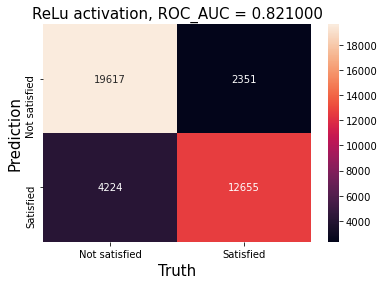

In [55]:
import seaborn as sns
labX = ["Not satisfied", "Satisfied"]
y_pred = np.where(y_pred > 0.5, 1, 0)


conf = confusion_matrix(Y_test, y_pred)
ROC_AUC = roc_auc_score(Y_test, y_pred)
sns.heatmap(conf, annot=True, fmt="d",  xticklabels = labX, yticklabels = labX)
plt.title('ReLu activation, ROC_AUC = %f' % (round(ROC_AUC, 3)), fontsize = 15)
plt.xlabel('Truth', fontsize = 15)
plt.ylabel('Prediction', fontsize = 15)

### Use autoencoder to reduce the dimension for classification (similar to Principal Component Analysis)

In [50]:
'''
A DNN can be used as an encoder where the output layer has only 2 perceptron.

In such a case, the results from the final two neurons can be used to cluster a data set just like 
Principal Component Analysis.

Here, we create a DNN with 2 hidden layers of 50 neurons each and the output layer with 2 neurons.

This autoencoder can be used to cluster the dataset into two clusters.

'''
ENCODING_DIM = 2
HIDDEN_DIM = 50
### BEGIN SOLUTION

# Encoder model
inputs = Input(shape=(22,)) 
encoder_hidden = Dense(HIDDEN_DIM, activation="relu")(inputs)
encoder_hidden2 = Dense(HIDDEN_DIM, activation="relu")(encoder_hidden)
encoded = Dense(ENCODING_DIM, activation="relu")(encoder_hidden2)
encoder_model = Model(inputs, encoded, name='encoder')

op1 = tensorflow.keras.optimizers.SGD(learning_rate=0.0001)

encoder_model.compile(optimizer=op1,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

encoder_model.fit(X_train, Y_train,
              batch_size=64,
              epochs=5,
              validation_data=(X_test, Y_test),
              shuffle=False)

Epoch 1/5
1417/1417 [==============================] - 3s 2ms/step - loss: 0.6867 - accuracy: 0.5770 - val_loss: 0.6251 - val_accuracy: 0.5568
Epoch 2/5
1417/1417 [==============================] - 3s 2ms/step - loss: 0.5888 - accuracy: 0.5375 - val_loss: 0.5567 - val_accuracy: 0.5214
Epoch 3/5
1417/1417 [==============================] - 2s 2ms/step - loss: 0.5366 - accuracy: 0.5040 - val_loss: 0.5163 - val_accuracy: 0.4932
Epoch 4/5
1417/1417 [==============================] - 2s 2ms/step - loss: 0.5024 - accuracy: 0.4846 - val_loss: 0.4887 - val_accuracy: 0.4774
Epoch 5/5
1417/1417 [==============================] - 3s 2ms/step - loss: 0.4826 - accuracy: 0.4626 - val_loss: 0.4692 - val_accuracy: 0.4539


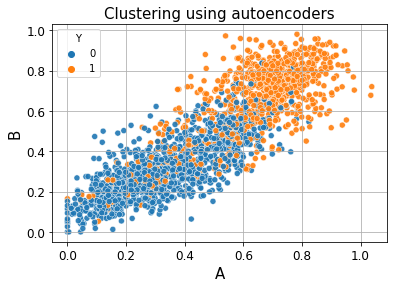

In [51]:
AE_predict = encoder_model.predict(X_test)
x_data = AE_predict[1:2000,0]
y_data = AE_predict[1:2000,1]
data = {'A': x_data0,
        'B': y_data1,
        'Y': Y_test[1:2000]}
dff = pd.DataFrame(data)

sns.scatterplot(data=dff, x="A", y="B", hue="Y", palette='tab10', alpha = 0.9)
plt.grid('on')
plt.xlabel('A', fontsize = 15)
plt.ylabel('B', fontsize= 15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Clustering using autoencoders', fontsize = 15);

## Summary of the analysis

In this notebook we used Deep Neural Network (DNN) to predict customer satisfaction from airline based on their ratings
on various features related to their travel. <br>

Due to large data set, use of DNN was justified. 

It must be noted here that classification using Decision Trees performed much better (ROC_AUC score of 0.946) compared to DNN with 3 hidden layers (6,301 trainable parameters) where the ROC_AUC score was 0.821.

This consolidates the fact that DNNs are not necessarily the best machine learning techniques for any given data set. In some cases, other machine learning algorithms such as Logistic Regression, Random forests, Decision trees etc. may perform better than a complicated DNN.
